In [1]:
import numpy as np
from refl1d.names import *
from refl1d.probe import QProbe
from refl1d.experiment import Experiment
import matplotlib.pyplot as plt


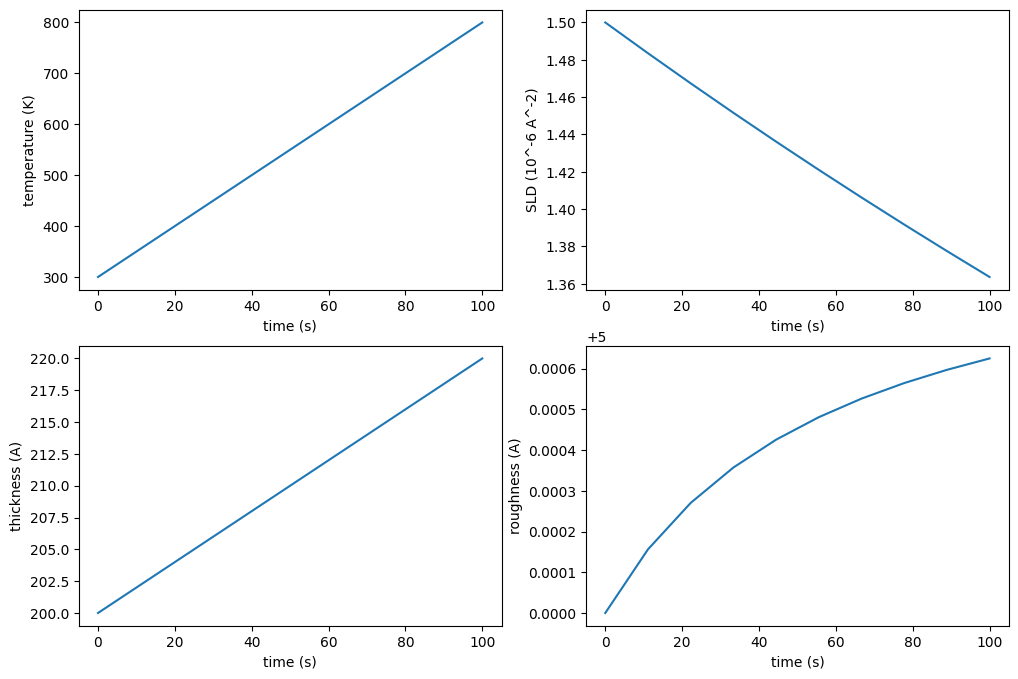

In [4]:
# define the initial layer properties at T0
layer_properties = {
    'substrate': {'sld': 2.07, 'thickness': 0.0, 'roughness': 0.0},
    'siox': {'sld': 3.47, 'thickness': 10.0, 'roughness': 3.0},
    'bottom': {'sld': 1.0, 'thickness': 50.0, 'roughness': 5.0},
    'bulk': {'sld': 1.5, 'thickness': 200.0, 'roughness': 5.0},
    'top_layer': {'sld': 1.2, 'thickness': 20.0, 'roughness': 3.0},
    'air': {'sld': 0.0, 'thickness': 0.0, 'roughness': 0.0}
}

t = np.linspace(0, 100, 10)

# time-resolved temperature change
# linear temperature change
# T(t) = T0 + t * dT
def Tt(t, T0=300, dT=5):
    return T0 + t * dT

# time-resolved scattering length density (SLD)
# SLD(t) = SLD0 / (1 + beta * (T(t) - T0))
def SLDt(T, beta=2E-4, T0=300, SLD0=1.5):
    return SLD0 / (1 + beta * (T - T0))

# time-resolved thickness
# thickness(t) = thickness0 * (1 + alpha * (T(t) - T0))
def thicknesst(T, alpha=2E-4, T0=300, thickness0=200):
    return thickness0 * (1 + alpha * (T - T0))

# time-resolved roughness
# roughness(t) = roughness0 * exp(gamma * t / T(t))
def roughnesst(t, gamma=1E-3, T0=300, roughness0=5):
    return roughness0 * np.exp(gamma * t / Tt(t, T0=T0))

# plot out the time-resolved layer properties
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.plot(t, Tt(t))
plt.xlabel('time (s)')
plt.ylabel('temperature (K)')
plt.subplot(222)
plt.plot(t, SLDt(Tt(t)))
plt.xlabel('time (s)')
plt.ylabel('SLD (10^-6 A^-2)')
plt.subplot(223)
plt.plot(t, thicknesst(Tt(t)))
plt.xlabel('time (s)')
plt.ylabel('thickness (A)')
plt.subplot(224)
plt.plot(t, roughnesst(t))
plt.xlabel('time (s)')
plt.ylabel('roughness (A)')
plt.show()


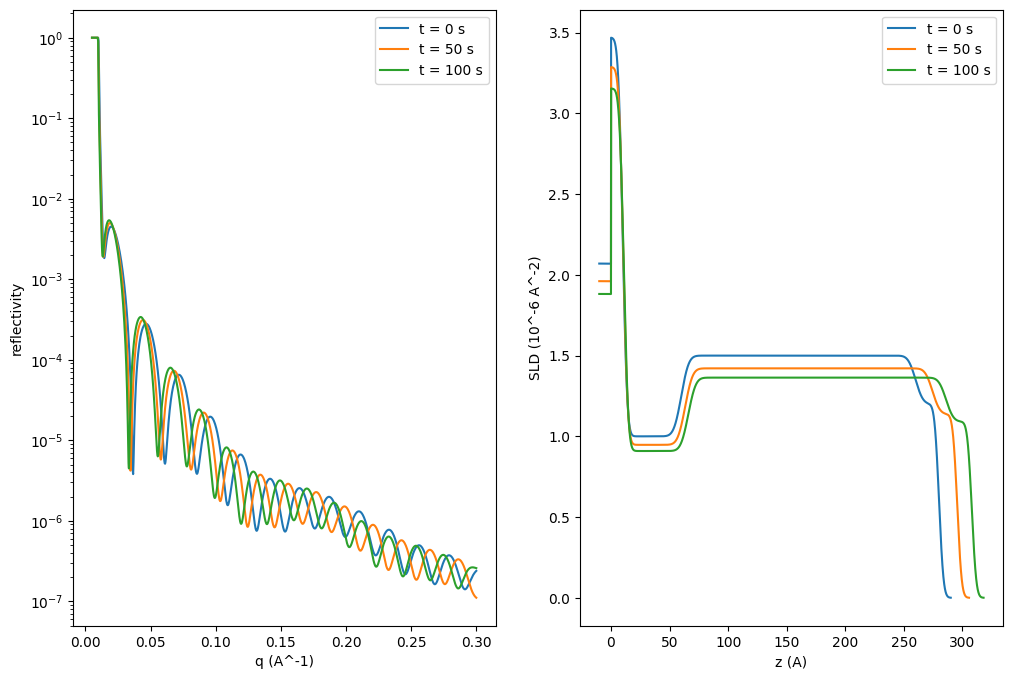

In [5]:
# define q range for the reflectivity calculation
q = np.linspace(0.005, 0.3, 1000)

# prepare lists for storing the reflectivity data
time_resolved_reflectivity = []
time_resolved_sld_profiles = []

for time in t:
    layers =[]
    first_layer = True
    sample = None
    for name, props in layer_properties.items():
        sld_now = SLDt(Tt(time), SLD0=props['sld'])
        thickness_now = thicknesst(Tt(time), thickness0=props['thickness'])
        roughness_now = roughnesst(time, roughness0=props['roughness'])
        if first_layer:
            sample = Slab(material=SLD(name=name, rho=sld_now), interface=roughness_now)
            first_layer = False
        else:
            sample |= Slab(material=SLD(name=name, rho=sld_now), thickness=thickness_now, interface=roughness_now)
    probe = QProbe(q, 0.01*q)
    M = Experiment(probe=probe, sample=sample)
    R = M.reflectivity()
    z, rho, irho = M.smooth_profile()
    time_resolved_reflectivity.append(R)
    time_resolved_sld_profiles.append((z, rho, irho))

# plot the first, middle and last reflectivity curves and sld profiles
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.plot(q, time_resolved_reflectivity[0][1], label='t = 0 s')
plt.plot(q, time_resolved_reflectivity[5][1], label='t = 50 s')
plt.plot(q, time_resolved_reflectivity[-1][1], label='t = 100 s')
plt.xlabel('q (A^-1)')
plt.ylabel('reflectivity')
plt.yscale('log')
plt.legend()
plt.subplot(122)
plt.plot(time_resolved_sld_profiles[0][0], time_resolved_sld_profiles[0][1], label='t = 0 s')
plt.plot(time_resolved_sld_profiles[5][0], time_resolved_sld_profiles[5][1], label='t = 50 s')
plt.plot(time_resolved_sld_profiles[-1][0], time_resolved_sld_profiles[-1][1], label='t = 100 s')
plt.xlabel('z (A)')
plt.ylabel('SLD (10^-6 A^-2)')
plt.legend()
plt.show()
